In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

import numpy as np
import shap
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

In [2]:
df = pd.read_csv('C:\\Users\\DMC CONET\\Documents\\python\\project1\\data\\기업정보상세.csv', encoding = 'utf-8-sig')
df_manpower = pd.read_csv('C:\\Users\\DMC CONET\\Documents\\python\\project1\\data\\인적자원정보.csv', encoding = 'cp949')
df_power = pd.read_csv('C:\\Users\\DMC CONET\\Documents\\python\\project1\\data\\사업화보유역량.csv', encoding = 'cp949')

In [3]:
df1 = pd.merge(df, df_power, on = '사업자등록번호', how = 'inner')
df1 = pd.merge(df1, df_manpower, on = '사업자등록번호', how = 'inner')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 863
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   사업자등록번호       864 non-null    int64  
 1   데이터수집일자_x     864 non-null    float64
 2   기업명           864 non-null    object 
 3   기업영문명         432 non-null    object 
 4   대표자명          864 non-null    object 
 5   종업원수          864 non-null    float64
 6   종업원수기준년월      864 non-null    float64
 7   산업분류코드_x      864 non-null    float64
 8   산업분류코드설명      864 non-null    object 
 9   기업규모          864 non-null    object 
 10  기업형태          864 non-null    object 
 11  업태명           864 non-null    object 
 12  설립일           864 non-null    float64
 13  이메일주소         240 non-null    object 
 14  전화번호          864 non-null    object 
 15  팩스전화번호        408 non-null    object 
 16  우편번호          432 non-null    float64
 17  주소            864 non-null    object 
 18  상세주보          432 non-null    

In [5]:
num_list = ['종업원수', '매출액_x', '영업이익', '자본총계금액', '부채총계금액', '자산총계금액', '사업화기반구축수준점수', '최종인적자원점수']

In [6]:
X = df1[num_list]
y = df1['CRI등급']

In [7]:
y.value_counts()

B2    264
A3    240
B1     72
B3     72
C2     72
C1     72
C3     48
A2     24
Name: CRI등급, dtype: int64

In [8]:
y1 = y.replace({'C3' : 0, 'C2' : 0, 'C1' : 0, 'B3' : 0, 'B2' : 1, 'B1' : 1, 'A3' : 1, 'A2' : 1, 'A1' : 1})
y2 = y.replace({'C3' : 0, 'C2' : 0, 'C1' : 0, 'B3' : 0, 'B2' : 0, 'B1' : 0, 'A3' : 1, 'A2' : 1, 'A1' : 1})

In [9]:
# y.replace({'C3' : 0, 'C2' : 1, 'C1' : 2, 'B3' : 3, 'B2' : 4, 'B1' : 5, 'A3' : 6, 'A2' : 7, 'A1' : 8}, inplace = True)

In [10]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train1, y_test1 = train_test_split(X, y1, random_state = 42)

In [12]:
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, random_state = 42)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_list])

X_train[num_list] = scaler.transform(X_train[num_list])
X_test[num_list] = scaler.transform(X_test[num_list])

In [24]:
X_train

,종업원수,매출액_x,영업이익,자본총계금액,부채총계금액,자산총계금액,사업화기반구축수준점수,최종인적자원점수
479,-0.423935,-0.513194,-1.761713,-1.950362,0.422520,-0.672957,-0.196963,0.556059
649,-0.391188,-0.506430,0.009145,-0.299817,-0.789869,-0.700181,-0.196963,-0.636293
528,3.756827,3.675057,3.366839,0.936437,2.966753,2.535749,-0.196963,-0.636293
558,3.156456,3.675057,3.366839,0.936437,2.966753,2.535749,-0.196963,-0.636293
862,-0.384638,-0.300026,0.034027,0.069271,-0.324324,-0.192026,-0.196963,2.687316
...,...,...,...,...,...,...,...,...
106,-0.428301,-0.557632,-0.156099,-0.762232,-0.792240,-0.931318,-0.196963,1.598647
270,-0.406470,-0.498850,0.171005,-0.466202,-0.659731,-0.691906,-0.196963,-0.498049
860,-0.384638,-0.300026,0.034027,0.069271,-0.324324,-0.192026,-0.196963,2.687316
435,-0.423935,-0.513194,-1.761713,-1.950362,0.422520,-0.672957,-0.196963,0.556059


In [14]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = XGBClassifier()
model.fit(X_train, y_train1)

hyper_parameters = {
    "max_depth" : range(5, 11),
    "subsample" : [0.5, 1]
}

grid_model = GridSearchCV(estimator = model, param_grid = hyper_parameters, cv = 3, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train, y_train1)

best_model1 = grid_model.best_estimator_

y_train_pred1 = best_model1.predict(X_train)
y_test_pred1 = best_model1.predict(X_test)

print(classification_report(y_train1, y_train_pred1))
print(classification_report(y_test1, y_test_pred1))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       211
           1       0.91      0.89      0.90       437

    accuracy                           0.87       648
   macro avg       0.85      0.86      0.85       648
weighted avg       0.87      0.87      0.87       648

              precision    recall  f1-score   support

           0       0.63      0.85      0.73        53
           1       0.94      0.84      0.89       163

    accuracy                           0.84       216
   macro avg       0.79      0.84      0.81       216
weighted avg       0.87      0.84      0.85       216



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

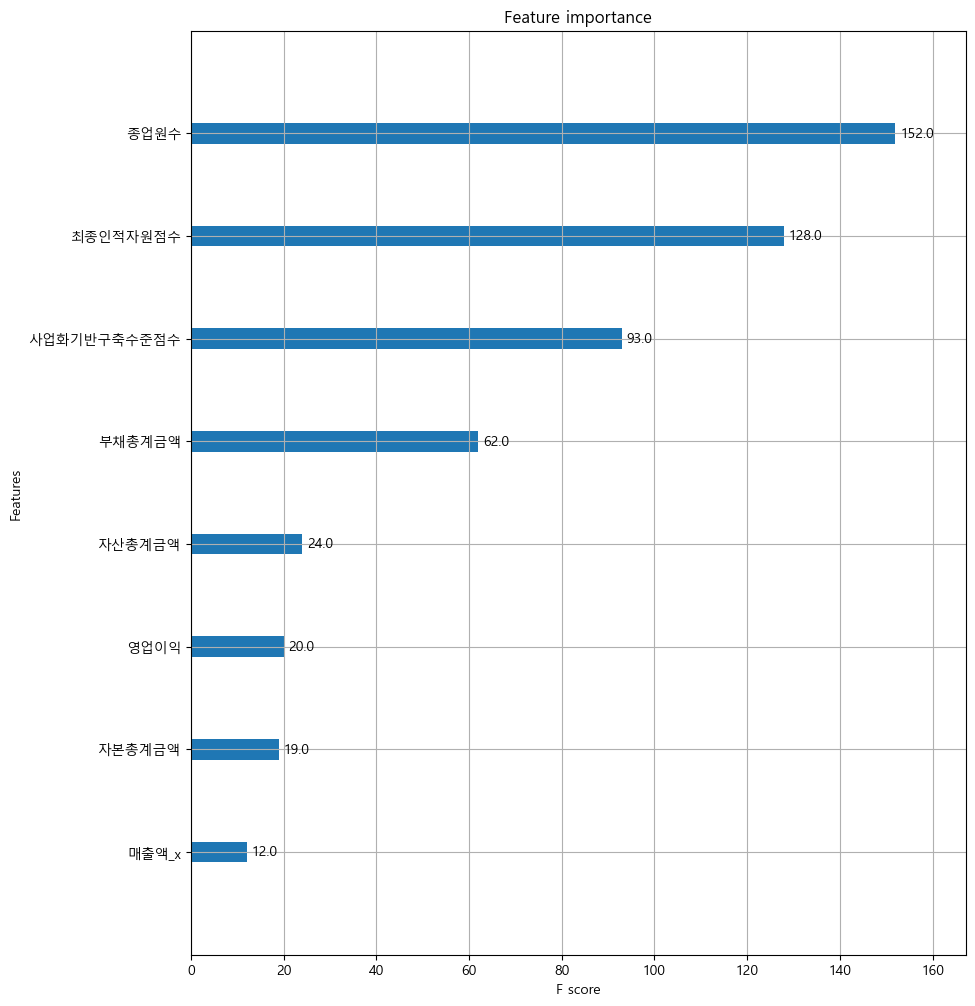

In [15]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(best_model1, ax=ax)

In [16]:
model = XGBClassifier()
model.fit(X_train, y_train2)

hyper_parameters = {
    "max_depth" : range(5, 11),
    "subsample" : [0.5, 1]
}

grid_model = GridSearchCV(estimator = model, param_grid = hyper_parameters, cv = 3, n_jobs = -1, scoring = 'f1')
grid_model.fit(X_train, y_train2)

best_model2 = grid_model.best_estimator_

y_train_pred2 = best_model2.predict(X_train)
y_test_pred2 = best_model2.predict(X_test)

print(classification_report(y_train2, y_train_pred2))
print(classification_report(y_test2, y_test_pred2))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       450
           1       0.69      0.70      0.70       198

    accuracy                           0.81       648
   macro avg       0.78      0.78      0.78       648
weighted avg       0.81      0.81      0.81       648

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       150
           1       0.67      0.58      0.62        66

    accuracy                           0.78       216
   macro avg       0.75      0.72      0.73       216
weighted avg       0.78      0.78      0.78       216



In [17]:
explainer1 = shap.Explainer(best_model1, X_test)
shap_values1 = explainer1(X_test)

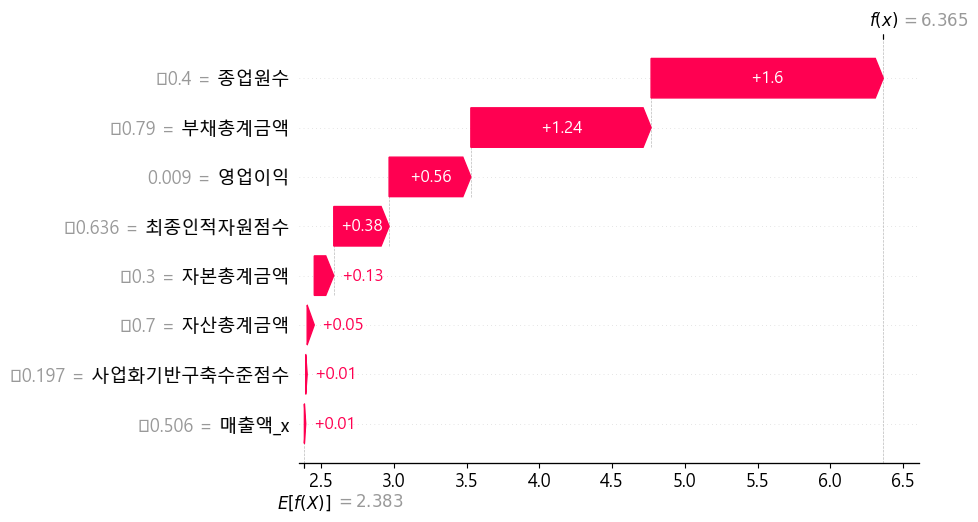

In [21]:
shap.plots.waterfall(shap_values1[1])

In [19]:
explainer2 = shap.Explainer(best_model2, X_test)
shap_values2 = explainer2(X_test)

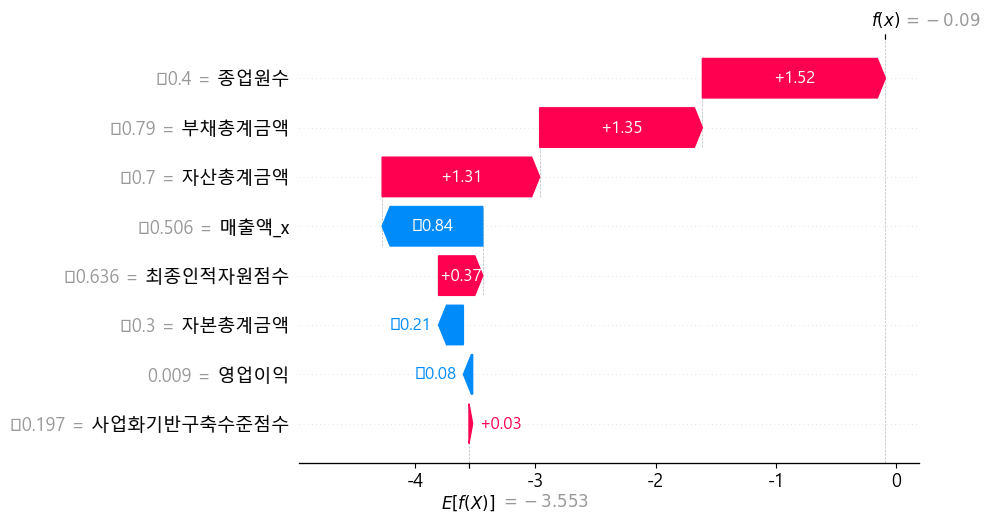

In [22]:
shap.plots.waterfall(shap_values2[1])